In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### <span style="color: red;">If you find this notebook helpful, please leave an UPVOTE to encourage me, it is very helpful!</span>

Changes yet to be done 
- data aug
- memes

# Importing Dependencies

In [37]:
import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image, display
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

import requests
from io import BytesIO
from tensorflow.keras.preprocessing import image as keras_image

from sklearn.metrics import f1_score, classification_report

import os

# Creating the DataFrame from the Dataset

In [11]:
all_paths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        all_paths.append(os.path.join(dirname, filename))

In [13]:
data = pd.DataFrame()
data = data.assign(filename=all_paths)
print(data.shape)
data.head()

(23873, 1)


filename
0  /kaggle/input/food-image-classification-datase...
1  /kaggle/input/food-image-classification-datase...
2  /kaggle/input/food-image-classification-datase...
3  /kaggle/input/food-image-classification-datase...
4  /kaggle/input/food-image-classification-datase...

#### We need to extract the labels from the path

In [14]:
data.loc[:, 'Labels'] = data.loc[:, 'filename'].apply(lambda x: x.split('/')[-2] if isinstance(x, str) else None)
data.head()

filename Labels
0  /kaggle/input/food-image-classification-datase...  momos
1  /kaggle/input/food-image-classification-datase...  momos
2  /kaggle/input/food-image-classification-datase...  momos
3  /kaggle/input/food-image-classification-datase...  momos
4  /kaggle/input/food-image-classification-datase...  momos

In [15]:
data.Labels.unique()

array(['momos', 'dhokla', 'kaathi_rolls', 'chole_bhature', 'masala_dosa',
       'Donut', 'Sandwich', 'Hot Dog', 'dal_makhani', 'burger',
       'omelette', 'Crispy Chicken', 'cheesecake', 'Fries', 'chai',
       'chicken_curry', 'chapati', 'paani_puri', 'pav_bhaji', 'pakode',
       'ice_cream', 'Baked Potato', 'idli', 'jalebi', 'Taco',
       'kadai_paneer', 'samosa', 'sushi', 'apple_pie', 'butter_naan',
       'pizza', 'Taquito', 'kulfi', 'fried_rice'], dtype=object)

Lets create a dictionary to help us for predictions

In [16]:
unique_labels = sorted(data.Labels.unique())
label_index_dict = {label: index for index, label in enumerate(unique_labels)}

print(label_index_dict)

{'Baked Potato': 0, 'Crispy Chicken': 1, 'Donut': 2, 'Fries': 3, 'Hot Dog': 4, 'Sandwich': 5, 'Taco': 6, 'Taquito': 7, 'apple_pie': 8, 'burger': 9, 'butter_naan': 10, 'chai': 11, 'chapati': 12, 'cheesecake': 13, 'chicken_curry': 14, 'chole_bhature': 15, 'dal_makhani': 16, 'dhokla': 17, 'fried_rice': 18, 'ice_cream': 19, 'idli': 20, 'jalebi': 21, 'kaathi_rolls': 22, 'kadai_paneer': 23, 'kulfi': 24, 'masala_dosa': 25, 'momos': 26, 'omelette': 27, 'paani_puri': 28, 'pakode': 29, 'pav_bhaji': 30, 'pizza': 31, 'samosa': 32, 'sushi': 33}


## Data Visualization

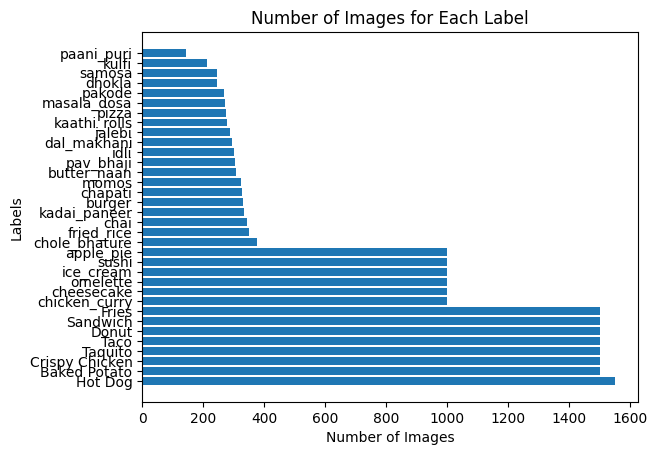

In [17]:
label_counts = data['Labels'].value_counts()

# Create a horizontal bar chart
plt.barh(label_counts.index, label_counts)

# Add labels and title
plt.xlabel('Number of Images')
plt.ylabel('Labels')
plt.title('Number of Images for Each Label')

# Display the plot
plt.show()

In [18]:
print(label_counts)

Labels
Hot Dog           1548
Baked Potato      1500
Crispy Chicken    1500
Taquito           1500
Taco              1500
Donut             1500
Sandwich          1500
Fries             1500
chicken_curry     1000
cheesecake        1000
omelette          1000
ice_cream         1000
sushi             1000
apple_pie         1000
chole_bhature      376
fried_rice         350
chai               344
kadai_paneer       334
burger             331
chapati            327
momos              323
butter_naan        307
pav_bhaji          305
idli               302
dal_makhani        295
jalebi             288
kaathi_rolls       279
pizza              275
masala_dosa        273
pakode             269
dhokla             245
samosa             244
kulfi              214
paani_puri         144
Name: count, dtype: int64


Holy that shit is so unbalanced dude

Insert daya he maa mata di meme here

Alright so for the non-Indian folks I'll just display one image of each label

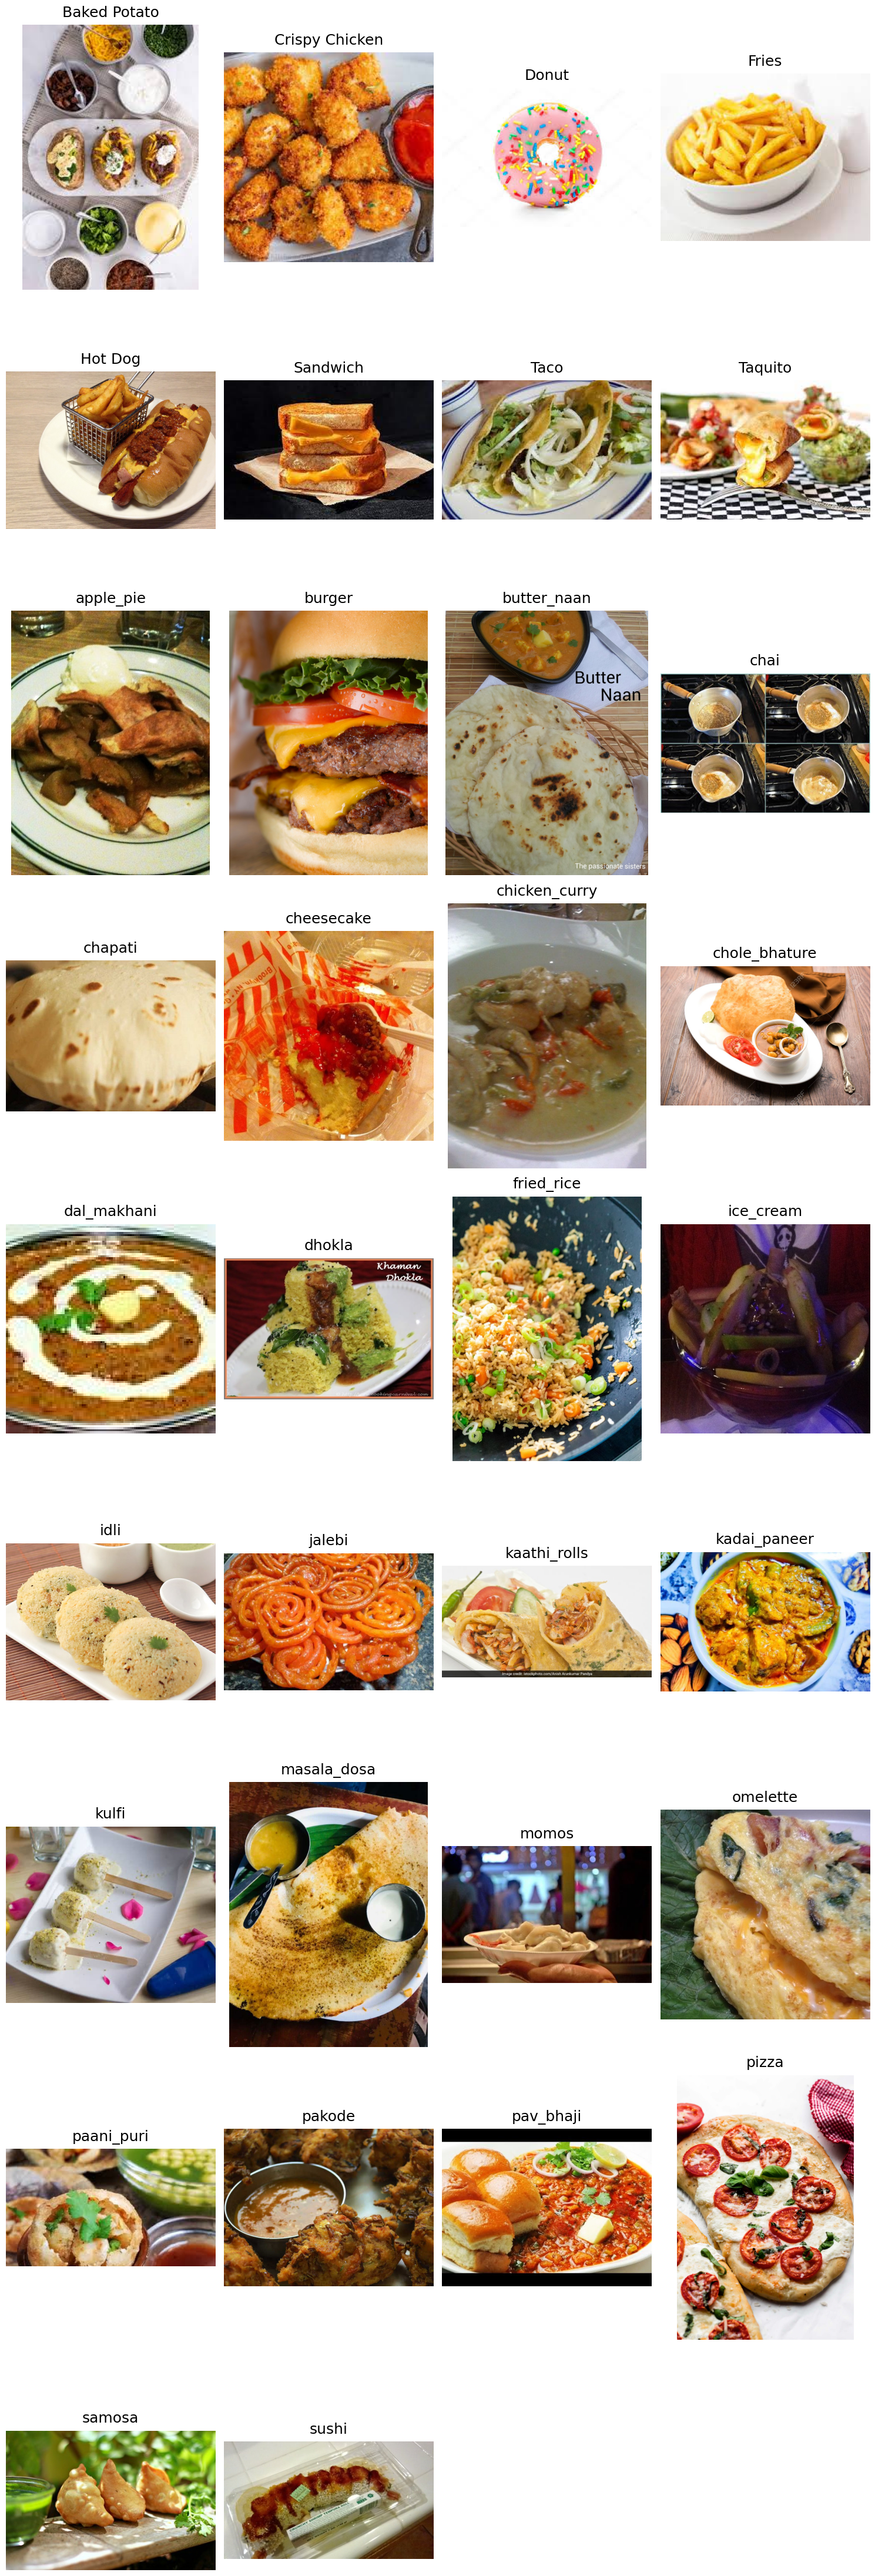

In [19]:
grouped_data = data.groupby('Labels')['filename'].apply(list)

# Calculate the number of rows and columns based on the desired number of columns
num_plots = len(grouped_data)
num_columns = 4  # Adjust the number of columns as needed
num_rows = (num_plots + num_columns - 1) // num_columns

# Set up subplots with multiple rows and columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Iterate through each group (label) and randomly select one image
for i, (label, filenames) in enumerate(grouped_data.items()):
    random_image_path = random.choice(filenames)
    
    img = plt.imread(random_image_path)
    
    axes[i].imshow(img)
    axes[i].set_title(label, pad=10, size=18)
    axes[i].axis('off')

# hide empty subplots
for j in range(num_plots, num_rows * num_columns):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Data Processing

In [ ]:
# we will come back later 

In [20]:
image_height = 351
image_weight = 351
batch_size = 10

tpath ='/kaggle/input/food-image-classification-dataset/Food Classification dataset'

In [21]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

train_batch = train_gen.flow_from_directory(
    directory=tpath,
    target_size=(300, 300),
    batch_size=64,
    subset='training',
    class_mode = 'categorical',
    seed=64
)
valid_batch = train_gen.flow_from_directory(
    directory=tpath,
    target_size=(300, 300),
    batch_size=64,
    subset='validation',
    class_mode = 'categorical',
    seed=64
)

Found 16720 images belonging to 34 classes.
Found 7153 images belonging to 34 classes.


# Training the Model

In [22]:
nb_train_samples = 16720 
nb_validation_samples = 7153 
batch_size = 10
n_classes = 34

In [24]:
inception = InceptionV3(weights='imagenet', include_top=False)

# Freeze layers up to the specified number
freeze_layers = 250
for layer in inception.layers[:freeze_layers]:
    layer.trainable = False


x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [26]:
history = model.fit(train_batch, batch_size = 16, epochs = 10, validation_data = valid_batch)

Epoch 1/10
 45/262 [====>.........................] - ETA: 7:32 - loss: 2.6282 - accuracy: 0.3778

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


262/262 [==============================] - 838s 3s/step - loss: 1.3927 - accuracy: 0.6813 - val_loss: 0.8226 - val_accuracy: 0.8247
Epoch 2/10
262/262 [==============================] - 649s 2s/step - loss: 0.6124 - accuracy: 0.8728 - val_loss: 0.6380 - val_accuracy: 0.8563
Epoch 3/10
262/262 [==============================] - 653s 2s/step - loss: 0.4081 - accuracy: 0.9182 - val_loss: 0.6266 - val_accuracy: 0.8543
Epoch 4/10
262/262 [==============================] - 646s 2s/step - loss: 0.2959 - accuracy: 0.9456 - val_loss: 0.6120 - val_accuracy: 0.8619
Epoch 5/10
262/262 [==============================] - 647s 2s/step - loss: 0.2285 - accuracy: 0.9621 - val_loss: 0.5586 - val_accuracy: 0.8711
Epoch 6/10
262/262 [==============================] - 646s 2s/step - loss: 0.1809 - accuracy: 0.9749 - val_loss: 0.5426 - val_accuracy: 0.8788
Epoch 7/10
262/262 [==============================] - 643s 2s/step - loss: 0.1489 - accuracy: 0.9802 - val_loss: 0.5247 - val_accuracy: 0.8816
Epoch 8/10

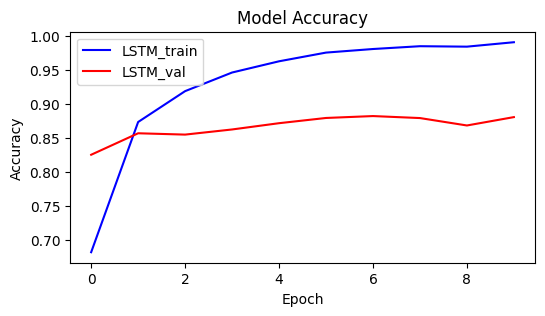

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

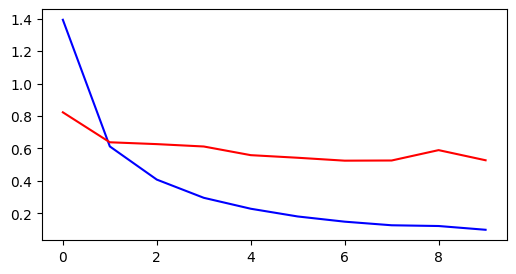

In [34]:
# Plotting accuracy
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], c='b', label='LSTM_train')
plt.plot(history.history['val_accuracy'], c='r', label='LSTM_val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plotting loss
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], c='b', label='LSTM_train')
plt.plot(history.history['val_loss'], c='r', label='LSTM_val')
plt


##### We have achieved an accuracy of about 88%, there is still room for improvement

# Saving the Model for Deployment Purpose

In [38]:
# Save the TensorFlow model in .h5 format

save_model(model, 'food_classification_model.h5')

/tmp/ipykernel_47/2324545261.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'food_classification_model.h5')


## Accuracy Metrics

In [42]:
# Function to predict labels given a generator
def predict_labels_from_generator(data_generator):
    predictions = []
    true_labels = []

    for i in range(len(data_generator)):
        images, labels = data_generator[i]
        predictions_batch = np.argmax(model.predict(images), axis=1)
        true_labels_batch = np.argmax(labels, axis=1)

        predictions.extend(predictions_batch)
        true_labels.extend(true_labels_batch)
        
        if i>100:
            break

    return np.array(predictions), np.array(true_labels)

In [43]:
# Predict labels for the validation set
valid_predictions, valid_true_labels = predict_labels_from_generator(valid_batch)

2/2 [==============================] - 0s 70ms/step


In [45]:
valid_f1 = f1_score(valid_true_labels, valid_predictions, average='weighted')
print("Validation F1 Score:", valid_f1)

Validation F1 Score: 0.8825459759887957


In [46]:
# Print Classification Report for validation set
valid_report = classification_report(valid_true_labels, valid_predictions)
print("Validation Classification Report:\n", valid_report)

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.91       406
           1       0.89      0.88      0.89       408
           2       0.91      0.94      0.93       410
           3       0.91      0.90      0.90       419
           4       0.87      0.85      0.86       423
           5       0.87      0.85      0.86       409
           6       0.77      0.79      0.78       414
           7       0.91      0.82      0.86       408
           8       0.81      0.77      0.79       280
           9       0.76      0.99      0.86        91
          10       0.87      0.94      0.91        87
          11       0.92      1.00      0.96        93
          12       0.94      0.82      0.87        88
          13       0.86      0.88      0.87       263
          14       0.90      0.84      0.87       272
          15       0.96      0.97      0.97       105
          16       0.88      0.99      0.93   

# Making Predictions

In [47]:
# Function to return the index of the image label
def find_max(preds):
    return np.argmax(preds)

In [48]:
# Function to preprocess the user-provided image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(351, 351))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [49]:
def get_label(pred_index):
    index_label_dict = {v: k for k, v in label_index_dict.items()}
    label = index_label_dict.get(pred_index, "Label not found")
    return label

In [55]:
# Function to perform classification on the user-provided image
def classify_image(img_path):
    processed_img = preprocess_image(img_path)
    predictions = model.predict(processed_img)
    decoded_prediction_index = find_max(predictions) 
    prediction_label = get_label(decoded_prediction_index)
    return str(prediction_label)

In [53]:
def print_image(img_path):
    # Load the image using matplotlib
    img = mpimg.imread(img_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

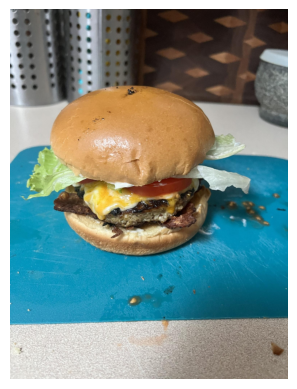

Predicted Label: 
1/1 [==============================] - 2s 2s/step


'burger'

In [56]:
# change this to try out different images!
# Change path according to your environment!
img_path = "/kaggle/input/burger-test/burgur_test.jpeg"
print_image(img_path)
print("Predicted Label: ")
classify_image(img_path)

#### <span style="color: red;">If you find this notebook helpful, please leave an UPVOTE to encourage me, it is very helpful!</span>